# WD in python with fortran

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from IPython.display import display, Math

import emcee
import subprocess
import sys
import re
import statistics
import corner
import pandas as pd
from threading import Timer

from multiprocessing import Pool
from multiprocessing import cpu_count

* Some useful constants

In [2]:
c = 299792458;            #[m/s]
UA = 149597870700;        #[m] #According https://aas.org/posts/story/2013/08/report-2012-iau-xxviii-general-assembly
pi = np.pi;

#According https://www.iau.org/static/resolutions/IAU2015_English.pdf 
G = 6.67408*10**(-11);    # 2014 CODATA 6.67408 (±0.00031)×10−11m3kg−1s−2
G_gauss = (2*pi)**2       # [year, AU, M_Sun] 
R_Sun = 6.957*10**(8);    #[m]
L_Sun = 3.827*10**(26)    #[W]
M_Sun = 1.9891*10**(30);  #[Kg]
R_Ear = 6.3781*10**(6);   #[m]
R_Jup = 7.1492*10**(7);   #[m]
M_Jup = 1.89813*10**(27); #[Kg]
T_Sun = 5778;

In [3]:
obj = 'TIC74386000'
x0, y0, ey0 = np.loadtxt('lc_TIC74386000.dat', unpack=True)
x0 = x0[:10050]
y0 = y0[:10050]
y0 = (y0/0.66667) - 0.49999
ey0 = ey0[:10050]

x_rv1, y_rv1, ey_rv1 = np.loadtxt('rv1_6678', unpack=True)
x_rv2, y_rv2, ey_rv2 = np.loadtxt('rv2_6678', unpack=True)

stars = []
stars2 = []

print(x0.shape)
print(x_rv1.shape)

(10050,)
(12,)


- Define initial values

In [4]:
p = prv = 33.62089659
ep = ept = eprvt = 2490.00686273
phase = -0.0672620

hjd = phase*p + ept
hjd

2487.7454539835635

In [5]:
# data for tic74386000
mode = 2
p = prv = 33.62089659
#ept = eprvt = 2487.7454539835635 #2490.00686273
T10_err1 = 200
T10_err2 = 200
ft = 1

albv1 = 0.5
albv2 = 0.5
hlv = 1.0
clv = 1.0
zvt = 0
ext_v0 = 0

flux_s = 1.00

vgat = 5.80
dpct = 0.00
dperrt = 0.00

#parametros a serem variados

at = 116.635715 #139.5248524
qt = 0.69 #0.77756 #0.7857090
it = 87.94521 #87.0172490
ecct = 0.268#9680 #0.268
perrt = 2.6298910
T1t = 2.500
T2t = 2.837186 #3.0671600 #2.8020020
phi1t = 28.084672 #17 #22.3585532
phi2t = 21.608544 #30 #22.5621353
phase0 = -0.0672620

F1 = F2 = np.sqrt((1+ecct)/(1/ecct)**3)

Bin T of the 10050 to 309


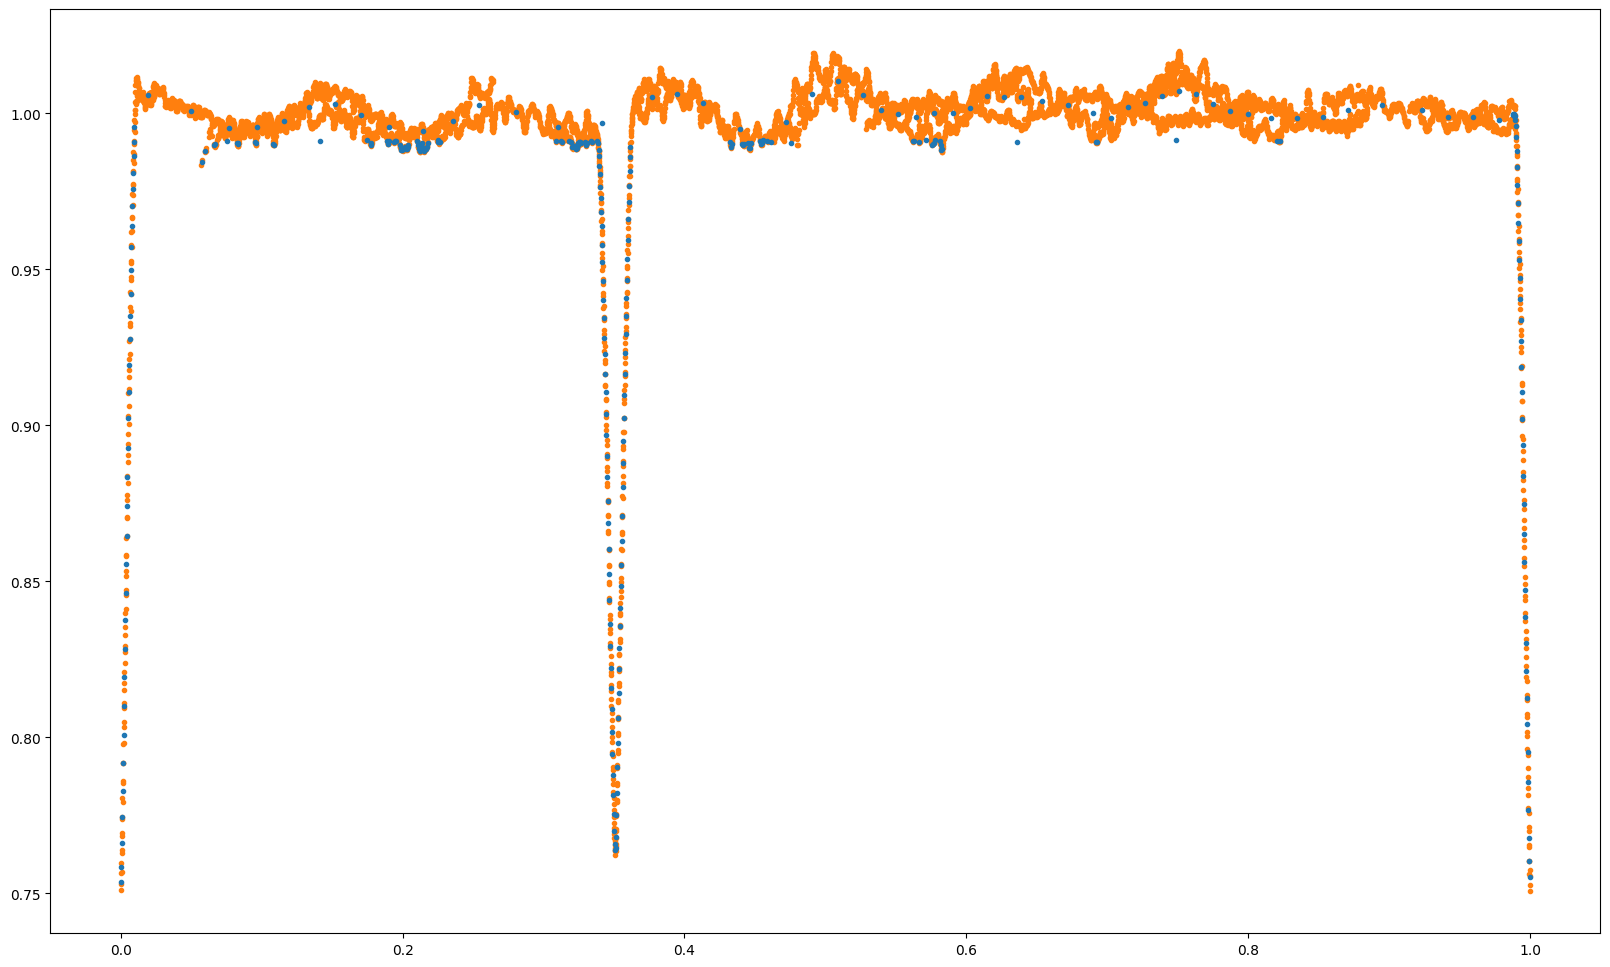

In [6]:
phase_0 = []
for t in range(len(x0)):
    aux_phase = (x0[t]-ep)/p - int((x0[t]-ep)/p)
    if aux_phase < 0:
        phase_0.append(aux_phase+1)
    else:
        phase_0.append(aux_phase)

aux = pd.DataFrame(np.column_stack([phase_0, y0, ey0]))
lc = np.column_stack([aux.sort_values(by=0)])


#======================================================================
aux_1 = []
aux_2 = []

for i in range(len(y0)):
    if lc[i,1] > 0.9915 and (0.01<lc[i,0]<0.34 or 0.36<lc[i,0]<0.9875):
        aux_1.append([lc[i,0], lc[i,1], lc[i,2]])
    else:
        aux_2.append([lc[i,0], lc[i,1], lc[i,2]])

aux1 = np.column_stack(aux_1)
aux2 = np.column_stack(aux_2)

#plt.figure(figsize=(16, 9))
#plt.errorbar(aux1[0], aux1[1], yerr=0, fmt="C1.")

#======================================================================

N = 175 #min = 2

n1 = N-1
n0 = 0

xn_v = int(len(aux1[0])/N)

phase  = np.array([])
y  = np.array([])
ey  = np.array([])

for n in range(xn_v):
    n0   = n0 + N
    n1   = n1 + N
    ax   = np.mean(aux1[0][n0-N:n1-N])
    ax1  = np.mean(aux1[1][n0-N:n1-N])
    ax2  = np.mean(aux1[2][n0-N:n1-N])
    phase   = np.append(phase,ax)
    y  = np.append(y,ax1)
    ey  = np.append(ey,ax2)

#======================================================================

N = 3 #min = 2

n1 = N-1
n0 = 0

xn_v = int(len(aux2[0])/N)

phase2  = np.array([])
y2  = np.array([])
ey2  = np.array([])

for n in range(xn_v):
    n0   = n0 + N
    n1   = n1 + N
    ax   = np.mean(aux2[0][n0-N:n1-N])
    ax1  = np.mean(aux2[1][n0-N:n1-N])
    ax2  = np.mean(aux2[2][n0-N:n1-N])
    phase2   = np.append(phase2,ax)
    y2  = np.append(y2,ax1)
    ey2  = np.append(ey2,ax2)

#=====================================================================

phase   = np.append(phase, phase2)#aux2[0])
y  = np.append(y,y2)#aux2[1])
ey  = np.append(ey,ey2)#aux2[2])

#=====================================================================

print('Bin T of the', len(phase_0), 'to', len(phase))

#=====================================================================

plt.figure(figsize=(20, 12))

plt.errorbar(phase_0, y0, yerr=0, fmt="C1.")
plt.errorbar(phase, y, yerr=0, fmt="C0.")

plt.savefig("lcbin_{}.pdf".format(obj))

In [7]:
def countLines(file):
    linicio = 0
    lfim = 0
    with open(file, "r") as l:
        for number, lines in enumerate(l):
            if re.findall(r'\s*JD\s+Phase', lines):
                linicio=number+1
            if linicio != 0 and re.findall(r'^$', lines):
                lfim = number - linicio
                break
    l.close()
    return linicio, lfim

def countLines2(file):
    linicio = 0
    lfim = 0
    with open(file, "r") as l:
        for number, lines in enumerate(l):
            if re.findall(r'\s*Star\s+M/Msun', lines):
                linicio=number
            if linicio != 0 and re.findall(r'^$', lines):
                lfim = number - linicio
                break
    l.close()
    return linicio, lfim

def countLines3(file):
    linicio = 0
    lfim = 0
    with open(file, "r") as l:
        for number, lines in enumerate(l):
            if re.findall(r'\s*Y\s+Sky', lines):
                linicio=number+1
            if linicio != 0 and re.findall(r'^$', lines):
                lfim = number - linicio
                break
    l.close()
    return linicio, lfim

def countLines4(file):
    linicio = 0
    lfim = 0
    with open(file, "r") as l:
        for number, lines in enumerate(l):
            if re.findall(r'\s*star\s+r pole', lines):
                linicio=number+2
            if linicio != 0 and re.findall(r'^$', lines):
                lfim = linicio+2
                break
    l.close()
    return linicio, lfim

# - Run wilson & devinney with fortran

In [8]:
lcin = "lcin.active"
lcout = "lcout.active"

stars  = []
radius = []
#band TESS
hjd = np.linspace(-0.25, 1.25, num=150)
np.savetxt('hjd.dat', hjd)

lixo = []
lixo2 = '{:1d} {:1d} {:1d} {:1d} {:1d} {:1d} {:1d} {:1d} {:2d} {:2d} {:1d} {:1d} {:1d} {:1d} {:6d}'.format(1, 2, 1, 0, 0, 1, 1, 0, -3, -3, 1, 1, 1, 0, 0)
lixo.append(lixo2)
lixo2 = '{:1d}{:15.6f}{:17.10f}{:14.6f}{:10.4f}{:8.5f}{:3d}{:11.4f}{:2d}{:11.0f}'.format(2, ept, p, 0.0000, phase0, 00.0000, 1, 0, 2, 138472375)
lixo.append(lixo2)  
lixo2 = '{:14.6f}{:15.6f}{:13.6f}{:12.6f}{:12.6f}{:12.6f}{:12.6f}{:10.4f}{:2d}{:8.4f}'.format(055369.000014, 0055369.018041, 00000.0000771, -00.250000, 000.750000, 000.000001, 000.250000, 0.7500, 1, 0.6640)
lixo.append(lixo2)  
lixo2 = '{:2d}{:2d}{:2d}{:2d}{:4d}{:4d}{:13.6f}{:14.6f}{:8.5f}{:8.2f}'.format(mode, 0, 1, 1, 30, 30, perrt, dperrt, 0.00000, 1.00)
lixo.append(lixo2)
lixo2 = '{:6.5f}{:12.6f}{:10.4f}{:10.4f}{:10.4f}{:9.3f}{:7.3f}{:7.3f}{:7.2f}{:10.4f}{:10.4f}'.format(ecct, at, F1, F2, vgat, it, 1.00, 1.00, -0.50, 1.0000, 1.0000)
lixo.append(lixo2)
lixo2 = '{:7.4f} {:7.4f}{:7.3f}{:7.3f}{:13.6f}{:13.6f}{:13.6f}{:7.3f}{:7.3f}{:7.3f}{:7.3f}{:8.5f}'.format(T1t, T2t, albv1, albv2, phi1t, phi2t, qt, 0.500, 0.600, 0.172, 0.163, dpct)
lixo.append(lixo2)
lixo2 = '{:12.6f}{:14.7f}{:11.5f}{:9.6f}{:10.7f}{:17.8f}'.format(0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
lixo.append(lixo2)  
lixo2 = '{:3d}{:13.7f}{:13.7f}{:7.3f}{:7.3f}{:7.3f}{:7.3f}{:12.4f}{:11.4f}{:8.3f}{:8.4f}{:10.6f}{:8.4f}{:12.5f}'.format(95, hlv, clv, 0.260, 0.225, -0.827, -0.723, 0.00000, 0.0000, zvt, flux_s, 0.55000, ext_v0, 0.378)
lixo.append(lixo2)
lixo2 = '{:9.5f}{:9.5f}{:9.5f}{:9.5f}{:14.5f}{:14.5f}{:14.5f}{:14.5f}'.format(0300.000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000)
lixo.append(lixo2)
lixo2 = '{:9.5f}{:9.5f}{:9.5f}{:9.5f}{:14.5f}{:14.5f}{:14.5f}{:14.5f}'.format(0300.000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000)
lixo.append(lixo2)
lixo2 = '{:3.0f}.'.format(150.)
lixo.append(lixo2)
lixo2 = '{:1.0f} '.format(9)
lixo.append(lixo2)

lixo3 = open(lcin, "w")
for line in lixo:
    # write line to output file
    lixo3.write(line)
    lixo3.write("\n")
lixo3.close()

#run W&D with fortran
subprocess.run(["./lc.e"])

linicio, lfim = countLines(lcout)
model_t = np.loadtxt(lcout, skiprows=linicio, max_rows=lfim, usecols=(5,))

linicio, lfim = countLines2(lcout)
stars.append(np.loadtxt(lcout, skiprows=linicio, max_rows=lfim, usecols=(0,1,2,3,4,5,6), dtype=str))

linicio, lfim = countLines4(lcout)
radius.append(np.loadtxt(lcout, skiprows=linicio, max_rows=lfim, usecols=(0, 1, 3, 5, 7), dtype=str))

#sadasd=asdsad

#rv1 e rv2
hjd = np.linspace(-0.25, 1.25, num=150)
np.savetxt('hjd.dat', hjd)

lixo = []
lixo2 = '{:1d} {:1d} {:1d} {:1d} {:1d} {:1d} {:1d} {:1d} {:2d} {:2d} {:1d} {:1d} {:1d} {:1d} {:6d}'.format(2, 2, 1, 0, 0, 1, 1, 0, -3, -3, 1, 1, 1, 0, 0)
lixo.append(lixo2)
lixo2 = '{:1d}{:15.6f}{:17.10f}{:14.6f}{:10.4f}{:8.5f}{:3d}{:11.4f}{:2d}{:11.0f}'.format(2, ept, p, 0.0000, phase0*2, 00.0000, 1, 0, 2, 138472375)
lixo.append(lixo2)  
lixo2 = '{:14.6f}{:15.6f}{:13.6f}{:12.6f}{:12.6f}{:12.6f}{:12.6f}{:10.4f}{:2d}{:8.4f}'.format(30979.347628, 30979.347628, 00000.10000, 00.00000, 001.000000, 000.010000, 000.250000, 0.7500, 1, 1.0140)
lixo.append(lixo2)  
lixo2 = '{:2d}{:2d}{:2d}{:2d}{:4d}{:4d}{:13.6f}{:14.6f}{:8.5f}{:8.2f}'.format(mode, 0, 1, 1, 30, 30, perrt, dperrt, 0.00000, 1.00)
lixo.append(lixo2)
lixo2 = '{:6.5f}{:12.6f}{:10.4f}{:10.4f}{:10.4f}{:9.3f}{:7.3f}{:7.3f}{:7.2f}{:10.4f}{:10.4f}'.format(ecct, at, F1, F2, vgat, it, 1.00, 1.00, -0.50, 1.0000, 1.0000)
lixo.append(lixo2)
lixo2 = '{:7.4f} {:7.4f}{:7.3f}{:7.3f}{:13.6f}{:13.6f}{:13.6f}{:7.3f}{:7.3f}{:7.3f}{:7.3f}{:8.5f}'.format(T1t, T2t, albv1, albv2, phi1t, phi2t, qt, 0.500, 0.600, 0.172, 0.163, dpct)
lixo.append(lixo2)
lixo2 = '{:12.6f}{:14.7f}{:11.5f}{:9.6f}{:10.7f}{:17.8f}'.format(0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
lixo.append(lixo2)  
lixo2 = '{:3d}{:13.7f}{:13.7f}{:7.3f}{:7.3f}{:7.3f}{:7.3f}{:12.4f}{:11.4f}{:8.3f}{:8.4f}{:10.6f}{:8.4f}{:12.5f}'.format(95, hlv, clv, 0.260, 0.225, -0.827, -0.723, 0.00000, 0.0000, zvt, flux_s, 0.55000, ext_v0, 0.378)
lixo.append(lixo2)
lixo2 = '{:9.5f}{:9.5f}{:9.5f}{:9.5f}{:14.5f}{:14.5f}{:14.5f}{:14.5f}'.format(0300.000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000)
lixo.append(lixo2)
lixo2 = '{:9.5f}{:9.5f}{:9.5f}{:9.5f}{:14.5f}{:14.5f}{:14.5f}{:14.5f}'.format(0300.000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000)
lixo.append(lixo2)
lixo2 = '{:3.0f}.'.format(150.)
lixo.append(lixo2)
lixo2 = '{:1.0f} '.format(9)
lixo.append(lixo2)

lixo3 = open(lcin, "w")
for line in lixo:
    # write line to output file
    lixo3.write(line)
    lixo3.write("\n")
lixo3.close()

#run W&D with fortran
subprocess.run(["./lc.e"])

linicio, lfim = countLines(lcout)
model_rv1 = np.loadtxt(lcout, skiprows=linicio, max_rows=lfim, usecols=(6,))

model_rv2 = np.loadtxt(lcout, skiprows=linicio, max_rows=lfim, usecols=(7,))
#adasd=asdsad

#dimensions
hjd_dim = [0.25]
np.savetxt('hjd.dat', hjd_dim)

lixo = []
lixo2 = '{:1d} {:1d} {:1d} {:1d} {:1d} {:1d} {:1d} {:1d} {:2d} {:2d} {:1d} {:1d} {:1d} {:1d} {:6d}'.format(5, 2, 1, 0, 0, 1, 1, 0, -3, -3, 1, 1, 1, 0, 0)
lixo.append(lixo2)
lixo2 = '{:1d}{:15.6f}{:17.10f}{:14.6f}{:10.4f}{:8.5f}{:3d}{:11.4f}{:2d}{:11.0f}'.format(2, ept, p, 0.0000, phase0, 00.0000, 1, 0, 2, 138472375)
lixo.append(lixo2)  
lixo2 = '{:14.6f}{:15.6f}{:13.6f}{:12.6f}{:12.6f}{:12.6f}{:12.6f}{:10.4f}{:2d}{:8.4f}'.format(30979.347628, 30979.347628, 00000.10000, 00.00000, 001.000000, 000.010000, 000.250000, 0.7500, 1, 1.0140)
lixo.append(lixo2)  
lixo2 = '{:2d}{:2d}{:2d}{:2d}{:4d}{:4d}{:13.6f}{:14.6f}{:8.5f}{:8.2f}'.format(mode, 0, 1, 1, 30, 30, perrt, dperrt, 0.00000, 1.00)
lixo.append(lixo2)
lixo2 = '{:6.5f}{:12.6f}{:10.4f}{:10.4f}{:10.4f}{:9.3f}{:7.3f}{:7.3f}{:7.2f}{:10.4f}{:10.4f}'.format(ecct, at, F1, F2, vgat, it, 1.00, 1.00, -0.50, 1.0000, 1.0000)
lixo.append(lixo2)
lixo2 = '{:7.4f} {:7.4f}{:7.3f}{:7.3f}{:13.6f}{:13.6f}{:13.6f}{:7.3f}{:7.3f}{:7.3f}{:7.3f}{:8.5f}'.format(T1t, T2t, albv1, albv2, phi1t, phi2t, qt, 0.500, 0.600, 0.172, 0.163, dpct)
lixo.append(lixo2)
lixo2 = '{:12.6f}{:14.7f}{:11.5f}{:9.6f}{:10.7f}{:17.8f}'.format(0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
lixo.append(lixo2)  
lixo2 = '{:3d}{:13.7f}{:13.7f}{:7.3f}{:7.3f}{:7.3f}{:7.3f}{:12.4f}{:11.4f}{:8.3f}{:8.4f}{:10.6f}{:8.4f}{:12.5f}'.format(95, hlv, clv, 0.260, 0.225, -0.827, -0.723, 0.00000, 0.0000, zvt, flux_s, 0.55000, ext_v0, 0.378)
lixo.append(lixo2)
lixo2 = '{:9.5f}{:9.5f}{:9.5f}{:9.5f}{:14.5f}{:14.5f}{:14.5f}{:14.5f}'.format(0300.000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000)
lixo.append(lixo2)
lixo2 = '{:9.5f}{:9.5f}{:9.5f}{:9.5f}{:14.5f}{:14.5f}{:14.5f}{:14.5f}'.format(0300.000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000)
lixo.append(lixo2)
lixo2 = '{:3.0f}.'.format(150.)
lixo.append(lixo2)
lixo2 = '{:1.0f} '.format(9)
lixo.append(lixo2)

lixo3 = open(lcin, "w")
for line in lixo:
    # write line to output file
    lixo3.write(line)
    lixo3.write("\n")
lixo3.close()

#run W&D with fortran
subprocess.run(["./lc.e"])

linicio, lfim = countLines3(lcout)
model_dim = np.loadtxt(lcout, skiprows=linicio, max_rows=lfim)

C:\Users\danilofr\AppData\Local\Temp\ipykernel_41508\1825604979.py:53: UserWarning: Input line 205 contained no data and will not be counted towards `max_rows=204`.  This differs from the behaviour in NumPy <=1.22 which counted lines rather than rows.  If desired, the previous behaviour can be achieved by using `itertools.islice`.
Please see the 1.23 release notes for an example on how to do this.  If you wish to ignore this warning, use `warnings.filterwarnings`.  This warning is expected to be removed in the future and is given only once per `loadtxt` call.
  radius.append(np.loadtxt(lcout, skiprows=linicio, max_rows=lfim, usecols=(0, 1, 3, 5, 7), dtype=str))


[array([['Star', 'M/Msun', '(Mean', 'Radius)/Rsun', 'M', 'Bol', 'Log'],
       ['1', '11.1429', '4.2974', '-4.78', '4.22', '0.10612D+41',
        '345.84090'],
       ['2', '7.6886', '4.0066', '-5.17', '4.12', '0.11549D+41',
        '376.36394']], dtype='<U12')]


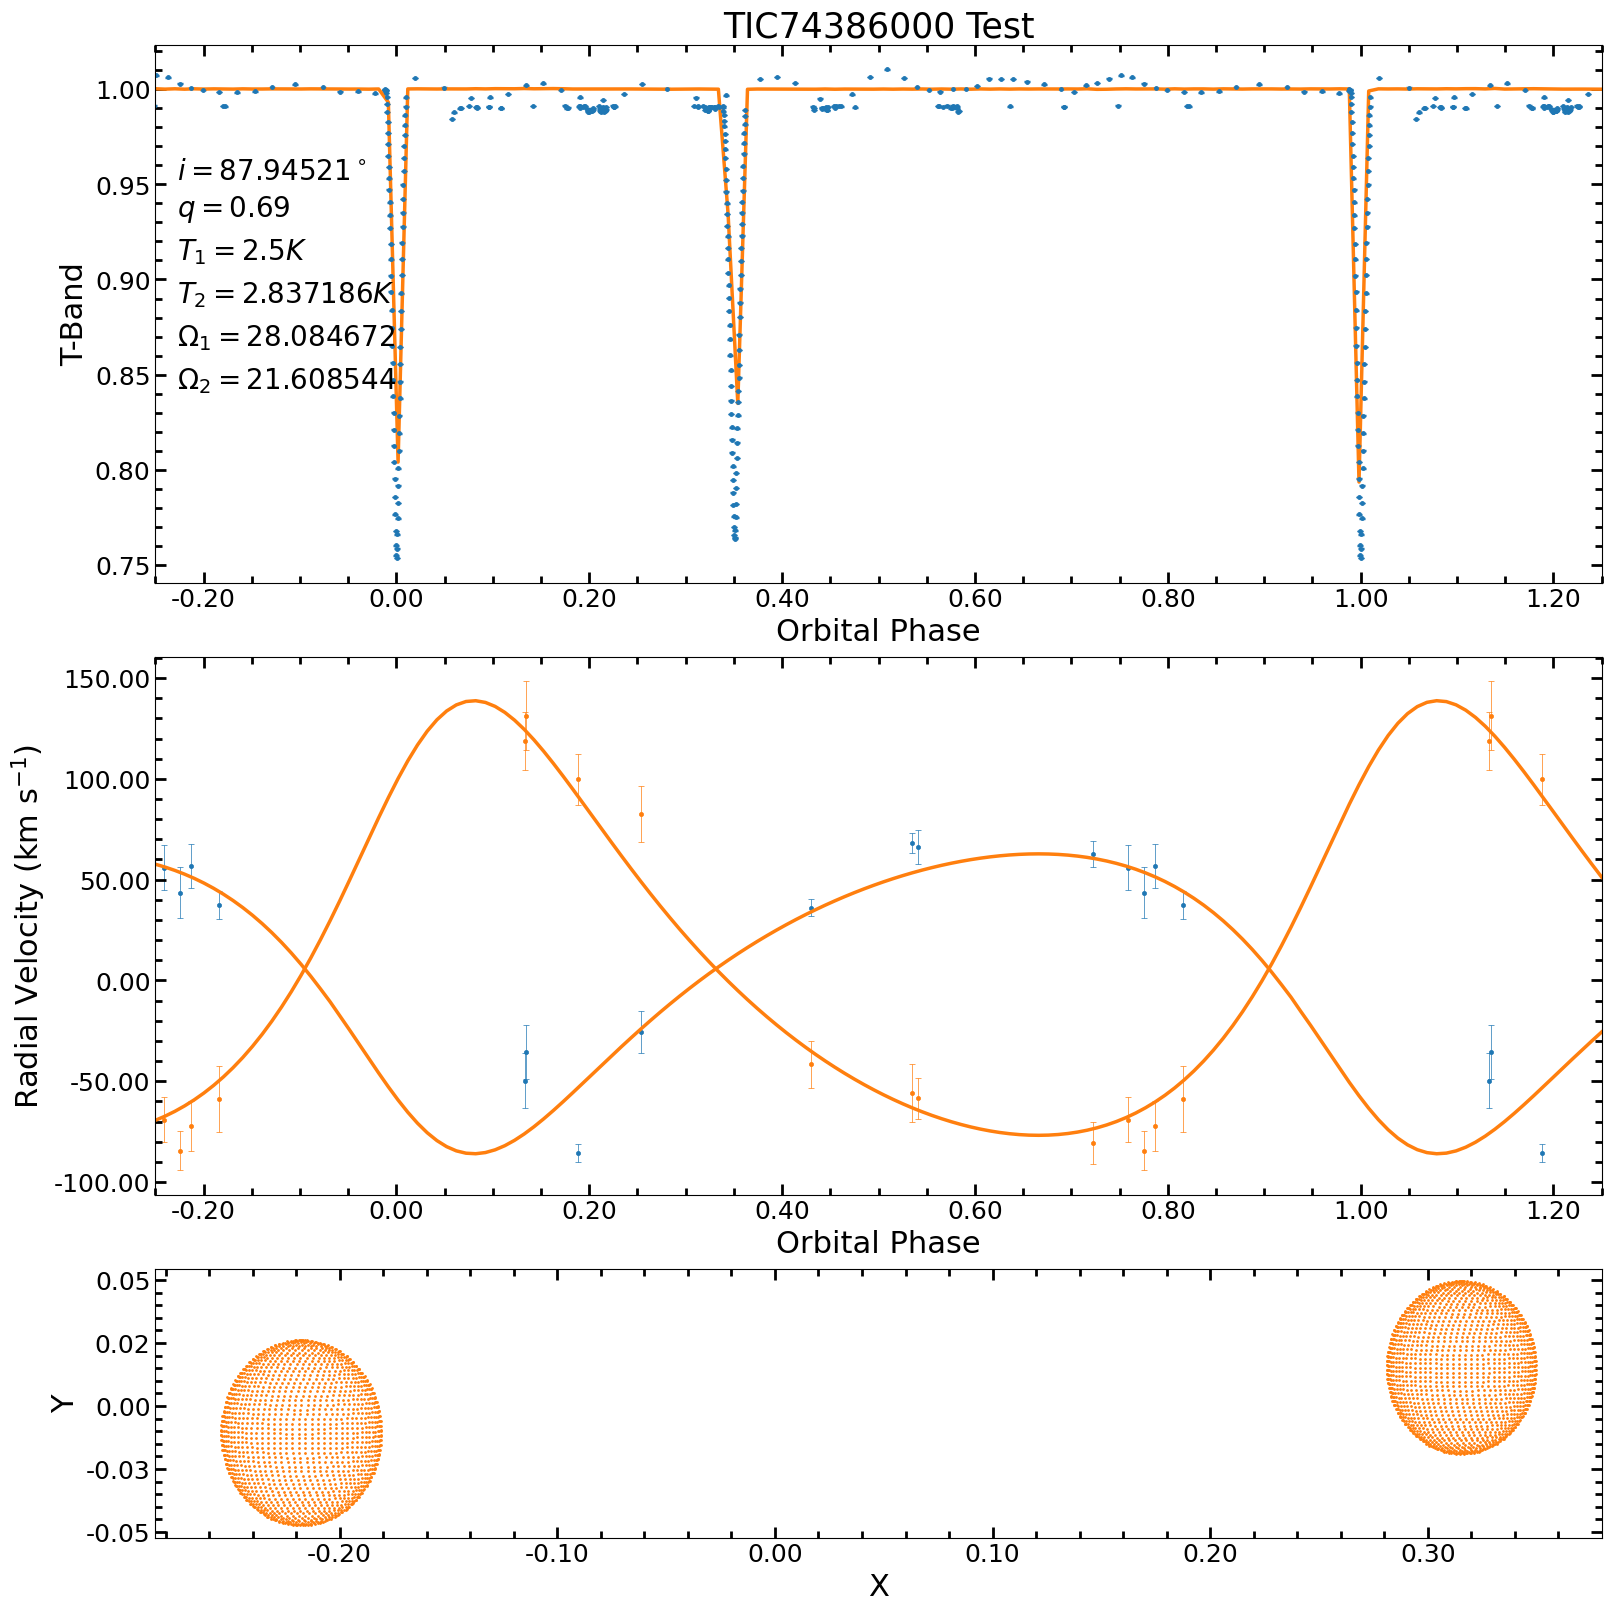

In [9]:
print(stars)

#============================

gs_kw = dict(height_ratios=[2, 2, 1])
fig, axs = plt.subplot_mosaic([['top'],
                               ['mid'],
                               ['bot']],
                              gridspec_kw=gs_kw, figsize=(16, 16),
                              constrained_layout=True)

axs['top'].set_title('TIC74386000 Test', size = 25)
axs['top'].annotate('$i = {}^\circ$'.format(it), xy=(0.015, 0.75), xycoords='axes fraction', fontsize=20)
axs['top'].annotate('$q = {}$'.format(qt), xy=(0.015, 0.68), xycoords='axes fraction', fontsize=20)
axs['top'].annotate('$T_1 = {} K$'.format(T1t), xy=(0.015, 0.60), xycoords='axes fraction', fontsize=20)
axs['top'].annotate('$T_2 = {} K$'.format(T2t), xy=(0.015, 0.52), xycoords='axes fraction', fontsize=20)
axs['top'].annotate('$\Omega_1 = {}$'.format(phi1t), xy=(0.015, 0.44), xycoords='axes fraction', fontsize=20)
axs['top'].annotate('$\Omega_2 = {}$'.format(phi2t), xy=(0.015, 0.36), xycoords='axes fraction', fontsize=20)


for k in axs:
    axs[k].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    axs[k].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    axs[k].minorticks_on()
    axs[k].tick_params(axis='both',which='minor', direction = "in",top = True,right = True, length=5,width=2,labelsize=18)
    axs[k].tick_params(axis='both',which='major', direction = "in",top = True,right = True, length=8,width=2,labelsize=18)


#===============================================================

axs['top'].set_ylabel("T-Band", size=22)
axs['top'].set_xlabel("Orbital Phase", size=22)
axs['top'].set_xlim(-0.25, 1.25)

phase2 = np.linspace(-0.25, 1.25, num=150)
        
axs['top'].errorbar(phase, y, yerr=ey, fmt="C0.", markersize=5, capsize=2)
axs['top'].errorbar(phase+1, y, yerr=ey, fmt="C0.", markersize=5, capsize=2)
axs['top'].errorbar(phase-1, y, yerr=ey, fmt="C0.", markersize=5, capsize=2)
axs['top'].plot(phase2, model_t, 'C1', linewidth=2.5)

#=======================================================

axs['mid'].set_xlabel("Orbital Phase", size=22)
axs['mid'].set_ylabel("Radial Velocity (km s$^{-1}$)", size=22)
axs['mid'].set_xlim(-0.25, 1.25)

axs['mid'].errorbar(x_rv1, y_rv1, yerr= ey_rv1, fmt="C0.", markersize=6, capsize=2, elinewidth=0.50, ecolor='C0', markeredgecolor='C0', markeredgewidth=0.50, zorder=0)
axs['mid'].errorbar(x_rv1+1, y_rv1, yerr= ey_rv1, fmt="C0.", markersize=6, capsize=2, elinewidth=0.50, ecolor='C0', markeredgecolor='C0', markeredgewidth=0.50, zorder=0)
axs['mid'].errorbar(x_rv1-1, y_rv1, yerr= ey_rv1, fmt="C0.", markersize=6, capsize=2, elinewidth=0.50, ecolor='C0', markeredgecolor='C0', markeredgewidth=0.50, zorder=0)
axs['mid'].errorbar(x_rv2, y_rv2, yerr= ey_rv2, fmt="C1.", markersize=6, capsize=2, elinewidth=0.50, ecolor='C1', markeredgecolor='C1', markeredgewidth=0.50, zorder=0)
axs['mid'].errorbar(x_rv2+1, y_rv2, yerr= ey_rv2, fmt="C1.", markersize=6, capsize=2, elinewidth=0.50, ecolor='C1', markeredgecolor='C1', markeredgewidth=0.50, zorder=0)
axs['mid'].errorbar(x_rv2-1, y_rv2, yerr= ey_rv2, fmt="C1.", markersize=6, capsize=2, elinewidth=0.50, ecolor='C1', markeredgecolor='C1', markeredgewidth=0.50, zorder=0)

axs['mid'].plot(phase2, model_rv1, 'C1', linewidth=2.5)
axs['mid'].plot(phase2, model_rv2, 'C1', linewidth=2.5)

aux = np.column_stack([phase2, model_rv1])
np.savetxt('rv1_model.dat', aux)
aux = np.column_stack([phase2, model_rv2])
np.savetxt('rv2_model.dat', aux)

#=======================================================

axs['bot'].set_xlabel("X", size=22)
axs['bot'].set_ylabel("Y", size=22)

axs['bot'].plot(model_dim[:,0], model_dim[:,1], '.C1', ms=2)#, label = radius)
#axs['bot'].legend(loc='center', fontsize = 13, markerscale = 3)

#axs['bot'].annotate('Star - rPole - rPoint - rSide - rBack', xy=(0.3, 0.89), xycoords='axes fraction', fontsize=15)
#=======================================================

plt.savefig('tic74386000_test.pdf')

#### 